In [1]:
# Imports
import sys
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from analysis.load_data import load_dataset
from analysis.config.model_config import FORECASTING_CONFIG
from analysis.forecasting.forecasting_utils import *

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [2]:
# Load Reddit Data
reddit_df = load_dataset('reddit')

print(f"Total posts: {len(reddit_df):,}")
print(f"Columns: {list(reddit_df.columns)}")
print(f"Date range: {reddit_df['DATE'].min()} to {reddit_df['DATE'].max()}")

# Calculate data span
date_range = (reddit_df['DATE'].max() - reddit_df['DATE'].min()).days
print(f"Days of data: {date_range}")
print(f"Weeks of data: {date_range / 7:.1f}")

# Check for nulls
print(f"\nData Quality:")
print(f"  Null TEXT values: {reddit_df['TEXT'].isnull().sum()}")
print(f"  Null DATE values: {reddit_df['DATE'].isnull().sum()}")
print(f"  Empty TEXT values: {(reddit_df['TEXT'] == '').sum()}")

# Display sample
print(f"\nSample data:")
print(reddit_df.head(3))

INFO:botocore.credentials:Found credentials in environment variables.
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 3.18.0, Python Version: 3.11.13, Platform: macOS-15.4.1-x86_64-i386-64bit
INFO:snowflake.connector.connection:Connecting to GLOBAL Snowflake domain
INFO:analysis.load_data:Loaded 2793 rows from reddit_extract.sql


Total posts: 2,793
Columns: ['SUBREDDIT', 'DATE', 'TITLE', 'TEXT', 'SCORE', 'COMMENTS']
Date range: 2025-07-15 to 2026-01-04
Days of data: 173
Weeks of data: 24.7

Data Quality:
  Null TEXT values: 0
  Null DATE values: 0
  Empty TEXT values: 24

Sample data:
      SUBREDDIT        DATE  \
0  mentalhealth  2025-07-16   
1  mentalhealth  2025-07-16   
2  mentalhealth  2025-07-16   

                                               TITLE  \
0                                 Wellness Wednesday   
1  Guys I want to make an online community for so...   
2                    Why do I wanna be a kid so bad?   

                                                TEXT  SCORE  COMMENTS  
0  >*“Sometimes the bravest and most important th...      1         0  
1                                 Anyone interested?     19        33  
2  I'm 17 and since i was 13 I've been wanting no...     10         7  


INFO:analysis.forecasting.forecasting_utils:Adding sentiment analysis to column 'TEXT'...
INFO:analysis.forecasting.forecasting_utils:  Using single-text mode
INFO:analysis.forecasting.forecasting_utils:  Sentiment column 'sentiment' added
INFO:analysis.forecasting.forecasting_utils:  Mean: -0.232, Std: 0.685



Reddit sentiment statistics:
count    2793.000000
mean       -0.231846
std         0.685327
min        -0.994600
25%        -0.875900
50%        -0.468300
75%         0.440400
max         0.999100
Name: sentiment, dtype: float64


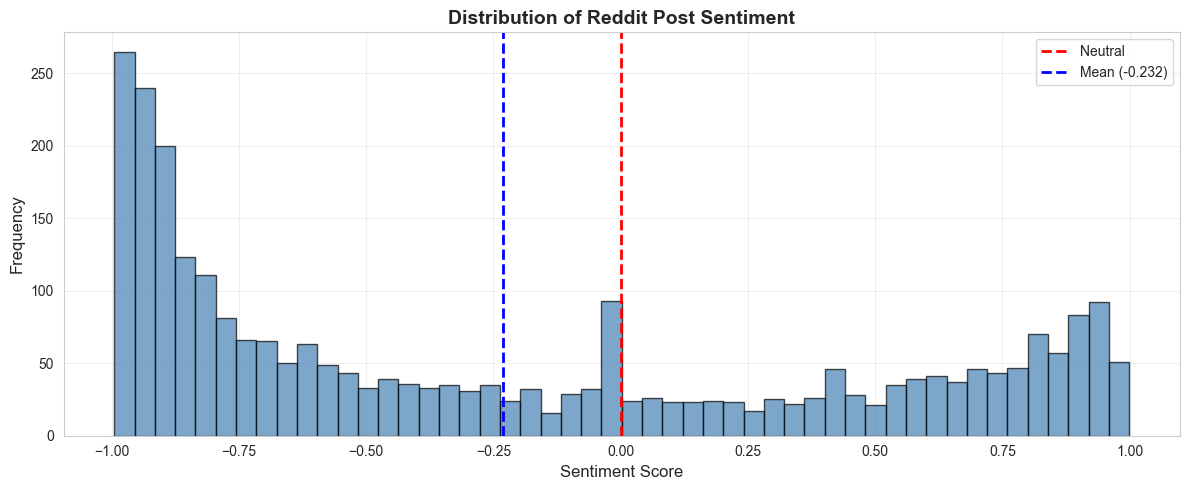


Reddit sentiment breakdown (thresholds: -0.05 to 0.05):
  Positive: 943 posts (33.8%)
  Neutral:  127 posts (4.5%)
  Negative: 1,723 posts (61.7%)


In [3]:
# Add sentiment analysis to Reddit
reddit_df = add_sentiment_column(
    df=reddit_df,
    text_column='TEXT',
    sentiment_column='sentiment',
    is_aggregated=False  # Each row is a single post
)

# Print Statistics
print(f"\nReddit sentiment statistics:")
print(reddit_df['sentiment'].describe())

# Show distribution
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(reddit_df['sentiment'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Reddit Post Sentiment', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
ax.axvline(x=reddit_df['sentiment'].mean(), color='blue', linestyle='--', 
           linewidth=2, label=f"Mean ({reddit_df['sentiment'].mean():.3f})")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Sentiment breakdown
pos_threshold = FORECASTING_CONFIG['sentiment']['positive_threshold']
neg_threshold = FORECASTING_CONFIG['sentiment']['negative_threshold']

n_positive = (reddit_df['sentiment'] > pos_threshold).sum()
n_neutral = ((reddit_df['sentiment'] >= neg_threshold) & 
             (reddit_df['sentiment'] <= pos_threshold)).sum()
n_negative = (reddit_df['sentiment'] < neg_threshold).sum()

print(f"\nReddit sentiment breakdown (thresholds: {neg_threshold} to {pos_threshold}):")
print(f"  Positive: {n_positive:,} posts ({n_positive/len(reddit_df)*100:.1f}%)")
print(f"  Neutral:  {n_neutral:,} posts ({n_neutral/len(reddit_df)*100:.1f}%)")
print(f"  Negative: {n_negative:,} posts ({n_negative/len(reddit_df)*100:.1f}%)")

Weekly aggregated data shape: (63, 5)
Weeks of data: 63

First 10 weeks:
        date  volume  sentiment   avg_score  avg_comments
0 2025-07-15       4  -0.354575  105.250000     57.000000
1 2025-07-16     141  -0.155801   10.056738      6.914894
2 2025-07-30       1   0.829500    2.000000      6.000000
3 2025-08-01       2   0.027150  289.500000     73.000000
4 2025-08-02     142  -0.166983   10.514085      6.605634
5 2025-09-10       1   0.829500    1.000000      2.000000
6 2025-09-15      11  -0.444591  186.818182     35.272727
7 2025-09-16     134  -0.157822    7.156716      3.440299
8 2025-09-17       1   0.829500    3.000000      5.000000
9 2025-09-21       6  -0.339700  150.833333     64.000000


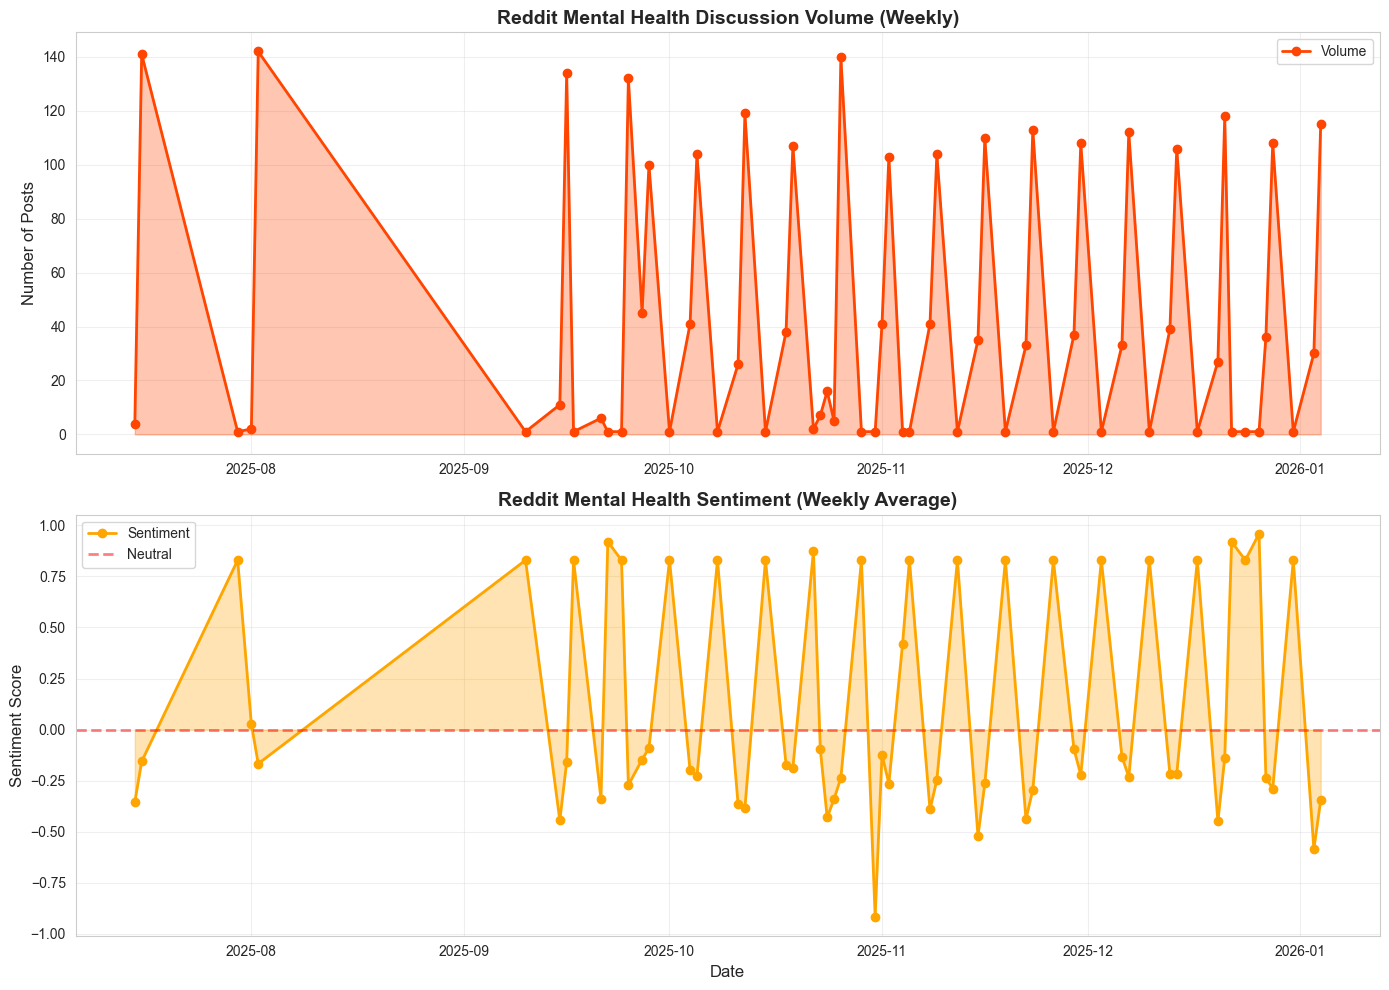


WEEKLY REDDIT STATISTICS
Volume:
  Mean:  44.3 posts/week
  Std:   50.3
  Range: 1 - 142

Sentiment:
  Mean:  0.109
  Std:   0.550
  Range: -0.915 - 0.959


In [5]:
# Aggregate Reddit data by week
reddit_df['DATE'] = pd.to_datetime(reddit_df['DATE'])

# Group by week
weekly_reddit = reddit_df.groupby('DATE').agg({
    'TEXT': 'count',        # Volume
    'sentiment': 'mean',    # Average sentiment
    'SCORE': 'mean',        # Average Reddit score
    'COMMENTS': 'mean'      # Average comments
}).reset_index()

# Rename columns
weekly_reddit.columns = ['date', 'volume', 'sentiment', 'avg_score', 'avg_comments']

print(f"Weekly aggregated data shape: {weekly_reddit.shape}")
print(f"Weeks of data: {len(weekly_reddit)}")
print(f"\nFirst 10 weeks:")
print(weekly_reddit.head(10))

# Plot both time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Volume over time
ax1.plot(weekly_reddit['date'], weekly_reddit['volume'], 
         marker='o', linewidth=2, color='#FF4500', label='Volume')
ax1.fill_between(weekly_reddit['date'], weekly_reddit['volume'], 
                  alpha=0.3, color='#FF4500')
ax1.set_title('Reddit Mental Health Discussion Volume (Weekly)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Posts', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sentiment over time
ax2.plot(weekly_reddit['date'], weekly_reddit['sentiment'], 
         marker='o', linewidth=2, color='orange', label='Sentiment')
ax2.fill_between(weekly_reddit['date'], weekly_reddit['sentiment'], 
                  alpha=0.3, color='orange')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, 
            linewidth=2, label='Neutral')
ax2.set_title('Reddit Mental Health Sentiment (Weekly Average)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Sentiment Score', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*70}")
print("WEEKLY REDDIT STATISTICS")
print(f"{'='*70}")
print(f"Volume:")
print(f"  Mean:  {weekly_reddit['volume'].mean():.1f} posts/week")
print(f"  Std:   {weekly_reddit['volume'].std():.1f}")
print(f"  Range: {weekly_reddit['volume'].min():.0f} - {weekly_reddit['volume'].max():.0f}")
print(f"\nSentiment:")
print(f"  Mean:  {weekly_reddit['sentiment'].mean():.3f}")
print(f"  Std:   {weekly_reddit['sentiment'].std():.3f}")
print(f"  Range: {weekly_reddit['sentiment'].min():.3f} - {weekly_reddit['sentiment'].max():.3f}")


In [7]:
# Load News data
news_df = load_dataset('news')

print(f"Total records: {len(news_df)} (already weekly aggregated)")
print(f"Columns: {list(news_df.columns)}")
print(f"\nSample data:")
print(news_df.head(3))

# Basic stats
print(f"\nDate range: {news_df['DATE'].min()} to {news_df['DATE'].max()}")
print(f"Weeks of data: {len(news_df)}")
print(f"Total articles: {news_df['ARTICLE_COUNT'].sum():,}")
print(f"Avg articles/week: {news_df['ARTICLE_COUNT'].mean():.1f}")

# Ensure DATE is datetime
news_df['DATE'] = pd.to_datetime(news_df['DATE'])

# Check delimiter
sample_headlines = str(news_df['SAMPLE_HEADLINES'].iloc[0])
print(f"Sample headlines (first 200 chars):")
print(sample_headlines[:200])

# Detect delimiter
delimiters = {';': sample_headlines.count(';'),
              '|': sample_headlines.count('|'),
              '||': sample_headlines.count('||')}
detected_delimiter = max(delimiters, key=delimiters.get)

print(f"\nDelimiter counts: {delimiters}")
print(f"Using delimiter: '{detected_delimiter}'")

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 3.18.0, Python Version: 3.11.13, Platform: macOS-15.4.1-x86_64-i386-64bit
INFO:snowflake.connector.connection:Connecting to GLOBAL Snowflake domain
INFO:analysis.load_data:Loaded 24 rows from news_extract.sql


Total records: 24 (already weekly aggregated)
Columns: ['DATE', 'ARTICLE_COUNT', 'SAMPLE_HEADLINES', 'SOURCES']

Sample data:
         DATE  ARTICLE_COUNT  \
0  2025-10-22             93   
1  2025-10-23             92   
2  2025-10-24             32   

                                    SAMPLE_HEADLINES  \
0  Mexico to Tax Mature Video Games | Pregnant IC...   
1  Villains To Be Removed at Disney Park: Will Ma...   
2  Psychologist Warns of Donald Trump’s ‘Massive ...   

                                             SOURCES  
0  NBC News, Landezine.com, Catholicnewsagency.co...  
1  Yahoo Entertainment, TheStranger.com, Rolling ...  
2  Bemorewithless.com, SFGate, New York Post, For...  

Date range: 2025-10-22 to 2026-01-03
Weeks of data: 24
Total articles: 1,268
Avg articles/week: 52.8
Sample headlines (first 200 chars):
Mexico to Tax Mature Video Games | Pregnant ICE Detainees Have Been Shackled, Forced Into Solitary Confinement | Driver Rams Vehicle into White House Gate, Taken 

INFO:analysis.forecasting.forecasting_utils:Adding sentiment analysis to column 'SAMPLE_HEADLINES'...
INFO:analysis.forecasting.forecasting_utils:  Using aggregated mode with delimiter '|'
INFO:analysis.forecasting.forecasting_utils:  Sentiment column 'sentiment' added
INFO:analysis.forecasting.forecasting_utils:  Mean: -0.053, Std: 0.187



News sentiment statistics:
count    24.000000
mean     -0.052752
std       0.186980
min      -0.333660
25%      -0.175450
50%      -0.047440
75%       0.058600
max       0.308140
Name: sentiment, dtype: float64

Example - Week 1:
  Date: 2025-10-22 00:00:00
  Articles: 93
  Headlines: Mexico to Tax Mature Video Games | Pregnant ICE Detainees Have Been Shackled, Forced Into Solitary C...
  Calculated Sentiment: -0.038

Weekly news data with sentiment:
        date  volume  sentiment
0 2025-10-22      93   -0.03772
1 2025-10-23      92   -0.32722
2 2025-10-24      32    0.03116
3 2025-10-25      97   -0.05710
4 2025-10-31      43   -0.03778


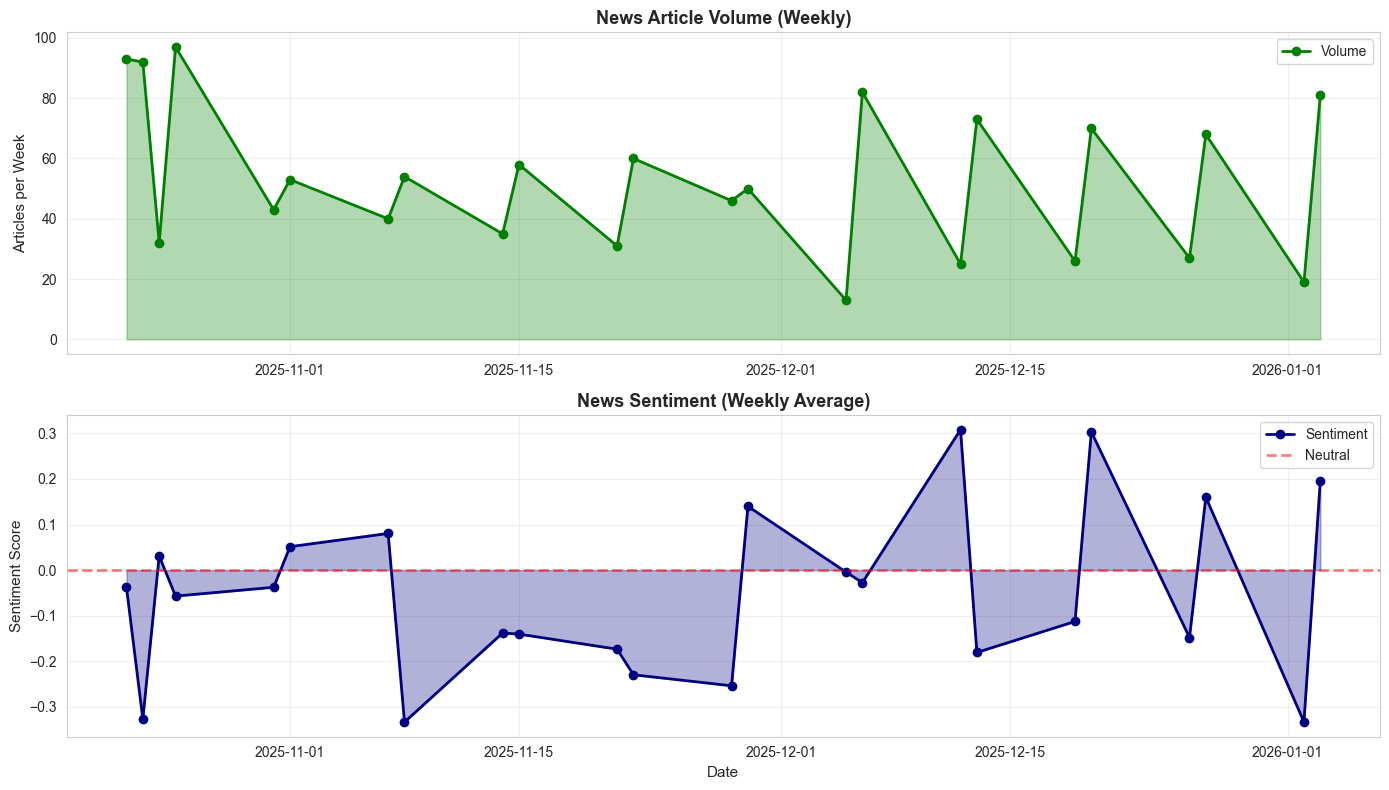

In [12]:

# Add sentiment analysis to News
news_df = add_sentiment_column(
    df=news_df,
    text_column='SAMPLE_HEADLINES',
    sentiment_column='sentiment',
    is_aggregated=True,  # Each row contains multiple headlines
    delimiter=detected_delimiter
)

print(f"\nNews sentiment statistics:")
print(news_df['sentiment'].describe())

# Show example
print(f"\nExample - Week 1:")
print(f"  Date: {news_df['DATE'].iloc[0]}")
print(f"  Articles: {news_df['ARTICLE_COUNT'].iloc[0]}")
print(f"  Headlines: {str(news_df['SAMPLE_HEADLINES'].iloc[0])[:100]}...")
print(f"  Calculated Sentiment: {news_df['sentiment'].iloc[0]:.3f}")

# Prepare for forecasting
weekly_news = news_df[['DATE', 'ARTICLE_COUNT', 'sentiment']].copy()
weekly_news.columns = ['date', 'volume', 'sentiment']

print(f"\nWeekly news data with sentiment:")
print(weekly_news.head())

# Plot news volume and sentiment
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Volume
ax1.plot(weekly_news['date'], weekly_news['volume'], 
         marker='o', linewidth=2, color='green', label='Volume')
ax1.fill_between(weekly_news['date'], weekly_news['volume'], 
                 alpha=0.3, color='green')
ax1.set_title('News Article Volume (Weekly)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Articles per Week', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sentiment
ax2.plot(weekly_news['date'], weekly_news['sentiment'], 
         marker='o', linewidth=2, color='navy', label='Sentiment')
ax2.fill_between(weekly_news['date'], weekly_news['sentiment'], 
                 alpha=0.3, color='navy')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Neutral')
ax2.set_title('News Sentiment (Weekly Average)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Sentiment Score', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

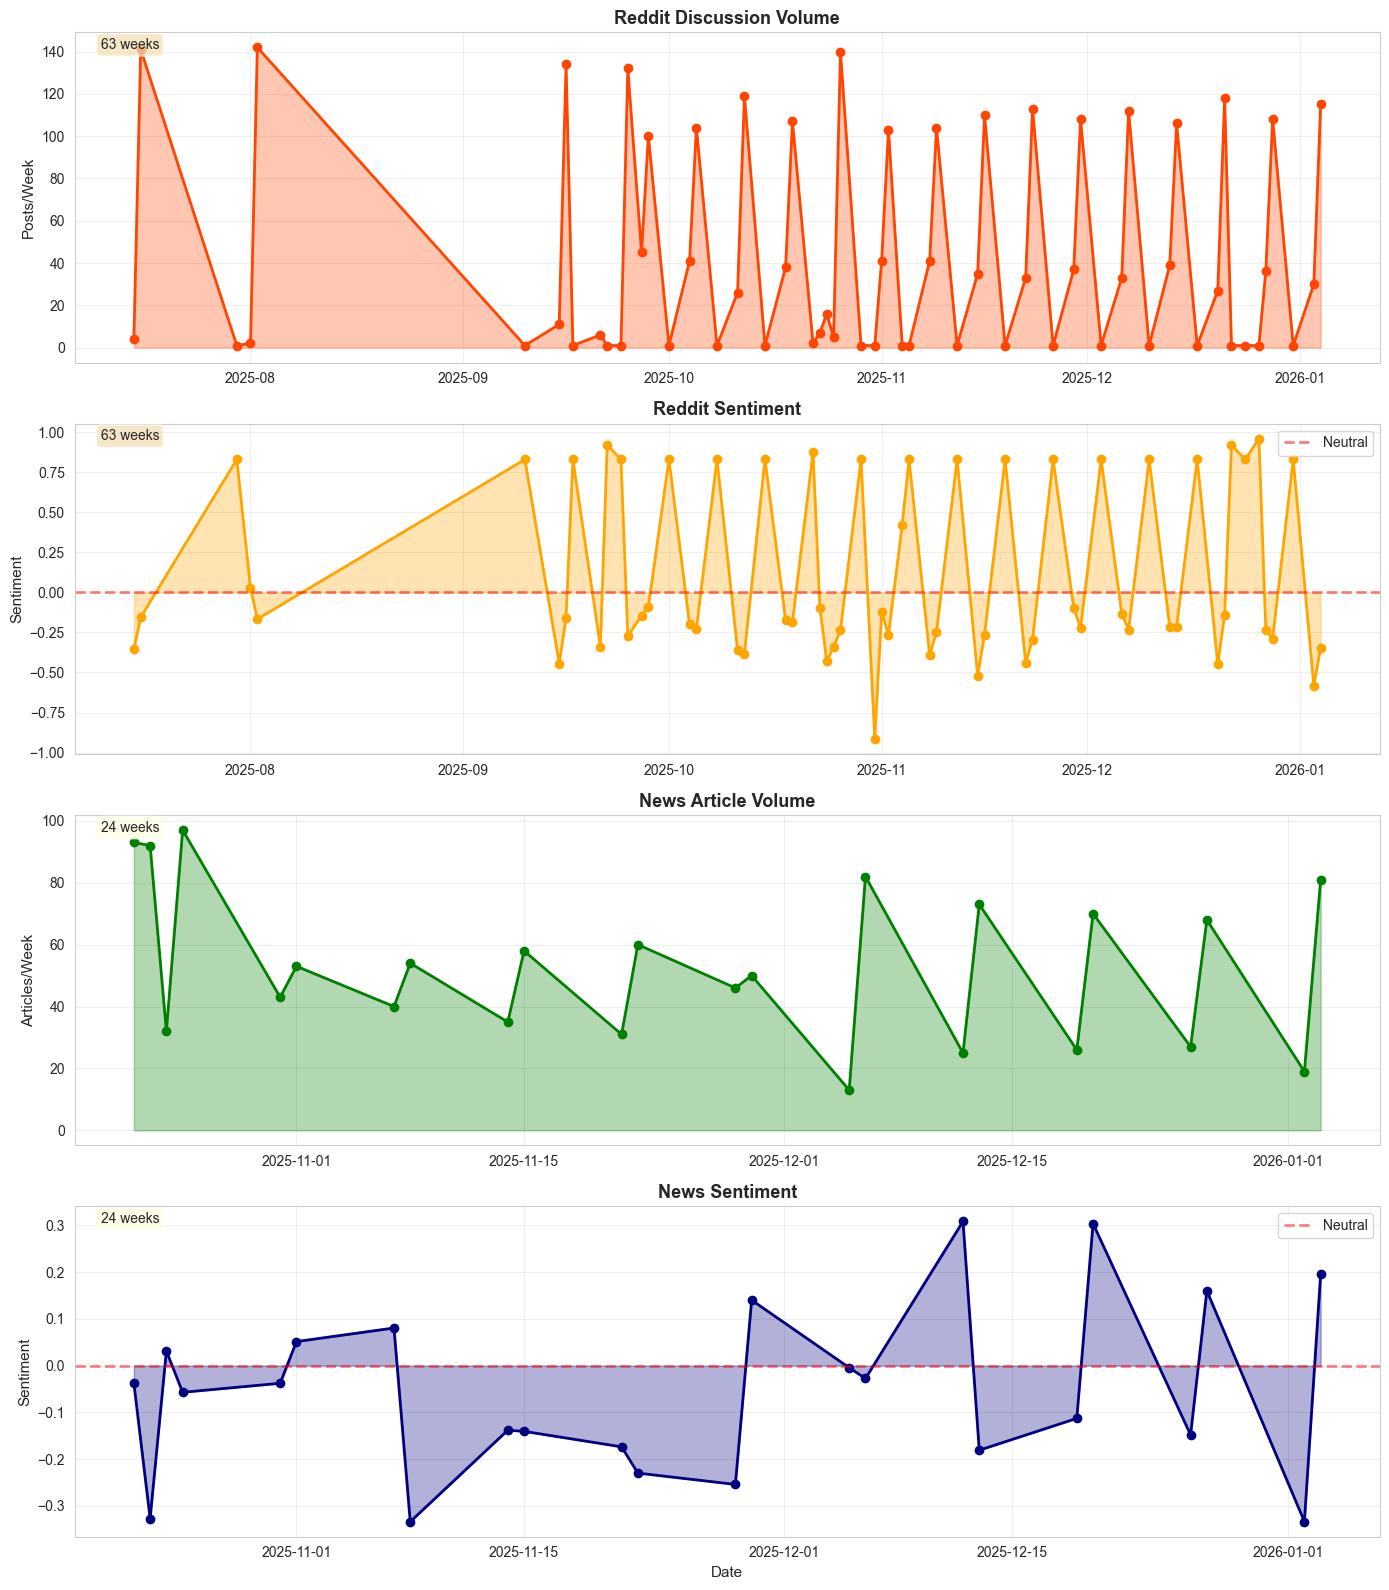

In [11]:
# Compare all 4 Time-Series
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Reddit Volume
axes[0].plot(weekly_reddit['date'], weekly_reddit['volume'], 
             marker='o', linewidth=2, color='#FF4500')
axes[0].fill_between(weekly_reddit['date'], weekly_reddit['volume'], 
                      alpha=0.3, color='#FF4500')
axes[0].set_title('Reddit Discussion Volume', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Posts/Week', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'{len(weekly_reddit)} weeks', 
             transform=axes[0].transAxes, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Reddit Sentiment
axes[1].plot(weekly_reddit['date'], weekly_reddit['sentiment'], 
             marker='o', linewidth=2, color='orange')
axes[1].fill_between(weekly_reddit['date'], weekly_reddit['sentiment'], 
                      alpha=0.3, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Neutral')
axes[1].set_title('Reddit Sentiment', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Sentiment', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].text(0.02, 0.95, f'{len(weekly_reddit)} weeks', 
             transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# News Volume
axes[2].plot(weekly_news['date'], weekly_news['volume'], 
             marker='o', linewidth=2, color='green')
axes[2].fill_between(weekly_news['date'], weekly_news['volume'], 
                      alpha=0.3, color='green')
axes[2].set_title('News Article Volume', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Articles/Week', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f'{len(weekly_news)} weeks', 
             transform=axes[2].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# News Sentiment
axes[3].plot(weekly_news['date'], weekly_news['sentiment'], 
             marker='o', linewidth=2, color='navy')
axes[3].fill_between(weekly_news['date'], weekly_news['sentiment'], 
                      alpha=0.3, color='navy')
axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Neutral')
axes[3].set_title('News Sentiment', fontsize=13, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=11)
axes[3].set_ylabel('Sentiment', fontsize=11)
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right')
axes[3].text(0.02, 0.95, f'{len(weekly_news)} weeks', 
             transform=axes[3].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()

In [14]:
# Summary comparison
print("DATA SUMMARY")
print(f"Reddit:  {len(weekly_reddit)} weeks | "
      f"{weekly_reddit['date'].min().date()} to {weekly_reddit['date'].max().date()}")
print(f"  Volume:    {weekly_reddit['volume'].mean():.1f} ± {weekly_reddit['volume'].std():.1f} posts/week")
print(f"  Sentiment: {weekly_reddit['sentiment'].mean():.3f} ± {weekly_reddit['sentiment'].std():.3f}")

print(f"\nNews:    {len(weekly_news)} weeks | "
      f"{weekly_news['date'].min().date()} to {weekly_news['date'].max().date()}")
print(f"  Volume:    {weekly_news['volume'].mean():.1f} ± {weekly_news['volume'].std():.1f} articles/week")
print(f"  Sentiment: {weekly_news['sentiment'].mean():.3f} ± {weekly_news['sentiment'].std():.3f}")

print(f"\nSentiment Comparison:")
reddit_sent_mean = weekly_reddit['sentiment'].mean()
news_sent_mean = weekly_news['sentiment'].mean()
sent_diff = reddit_sent_mean - news_sent_mean
print(f"  Reddit avg:  {reddit_sent_mean:.3f}")
print(f"  News avg:    {news_sent_mean:.3f}")
print(f"  Difference:  {sent_diff:+.3f} ({'Reddit more positive' if sent_diff > 0 else 'News more positive'})")


DATA SUMMARY
Reddit:  63 weeks | 2025-07-15 to 2026-01-04
  Volume:    44.3 ± 50.3 posts/week
  Sentiment: 0.109 ± 0.550

News:    24 weeks | 2025-10-22 to 2026-01-03
  Volume:    52.8 ± 24.8 articles/week
  Sentiment: -0.053 ± 0.187

Sentiment Comparison:
  Reddit avg:  0.109
  News avg:    -0.053
  Difference:  +0.161 (Reddit more positive)


In [ ]:
# Train Reddit Volume Model

In [ ]:
# Tune hyperparameters
if len(weekly_reddit) >= 20:  # Only tune if you have enough data
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1],
        'seasonality_prior_scale': [1.0, 10.0, 20.0]
    }
    best_params = hyperparameter_search(weekly_reddit, 'volume', param_grid, 'Reddit Volume')
    # Merge with base config
    tuned_config = {**FORECASTING_CONFIG['prophet'], **best_params}
else:
    tuned_config = FORECASTING_CONFIG['prophet']

# Train with tuned or default config
reddit_volume_model, reddit_volume_data = train_prophet_model(
    df=weekly_reddit,
    value_col='volume',
    model_name='Reddit Volume',
    config=tuned_config
)

In [ ]:
# Visualize all forecasts
fig, axes = plt.subplots(len(forecast_results), 2, figsize=(20, 6*len(forecast_results)))

for i, (dataset_name, results) in enumerate(forecast_results.items()):
    model = results['model']
    forecast = results['forecast']
    
    # Main forecast plot
    fig1 = model.plot(forecast, ax=axes[i,0])
    axes[i,0].set_title(f'{dataset_name.replace("_", " ").title()} Forecast')
    axes[i,0].set_ylabel('Value')
    
    # Components plot
    fig2 = model.plot_components(forecast, ax=axes[i,1] if len(forecast_results) == 1 else None)
    if len(forecast_results) > 1:
        # For multiple subplots, create separate components plot
        plt.figure(figsize=(12, 8))
        model.plot_components(forecast)
        plt.suptitle(f'{dataset_name.replace("_", " ").title()} Components')
        plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model performance
evaluation_results = {}

for dataset_name, results in forecast_results.items():
    training_data = results['training_data']
    
    if len(training_data) > 30:
        # Split data for validation
        train_size = int(len(training_data) * 0.8)
        train_data = training_data[:train_size]
        test_data = training_data[train_size:]
        
        # Train evaluation model
        eval_model = train_prophet_model(train_data, config)
        
        # Evaluate performance
        metrics = evaluate_forecast_model(eval_model, train_data, test_data, model_type='prophet')
        evaluation_results[dataset_name] = metrics
        
        print("Model Evaluation Metrics:")
        for metric, value in metrics.items():
            print(f"  {metric.upper()}: {value:.3f}")
    else:
        print(f"Insufficient data for evaluation ({len(training_data)} points)")
        evaluation_results[dataset_name] = None

In [ ]:
# Save all models/results
timestamp = pd.Timestamp.now().strftime("%Y%m%d")

for dataset_name, results in forecast_results.items():
    model = results['model'] 
    forecast = results['forecast']
    
    filename = f'{dataset_name}_{timestamp}'
    save_forecast_results(model, forecast, filename)

In [ ]:
# Cross-validation
cv_results = {}

for dataset_name, results in forecast_results.items():
    training_data = results['training_data']

    # Adjust minimum data requirements based on frequency
    min_required = 365 if dataset_name != 'who_suicides' else 15  # 15 years for annual data
    
    if len(training_data) > min_required:
        try:
            cv_output, cv_metrics = cross_validate_timeseries(training_data, config)
            cv_results[dataset_name] = cv_metrics
            
            print("Cross-validation metrics summary:")
            print(cv_metrics[['mape', 'rmse']].describe())
            
        except Exception as e:
            print(f"Cross-validation failed: {e}")
            cv_results[dataset_name] = None
    else:
        print(f"Need more data for cross-validation ({len(training_data)}/{min_required} points)")
        cv_results[dataset_name] = None